In this code, we will import the samples dictionary from the calibration procedure and create
1. A fit to the data
2. A corner plot

In [160]:
# Preamble
import corner
import pandas as pd
import json
import numpy as np
from IPython.display import IFrame
import matplotlib.pyplot as plt

from covid19model.models import models
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, make_contact_matrix_function
from covid19model.models.utils import initial_state
# from covid19model.optimization.run_optimization import checkplots, calculate_R0
# from covid19model.optimization.objective_fcns import prior_custom, prior_uniform
from covid19model.data import mobility, sciensano, model_parameters
# from covid19model.optimization import pso, objective_fcns
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.visualization.optimization import autocorrelation_plot, traceplot, plot_fit, plot_calibration_fit
from covid19model.visualization.utils import moving_avg
from covid19model.optimization.utils import perturbate_PSO, run_MCMC
from covid19model.optimization.utils import samples_dict_to_emcee_chain # used for corner plots
import random
import datetime

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Postprocessing WAVE1

In [139]:
##################
### USER INPUT ###
##################

# can take a while

# Simulation properties
agg = 'arr'
job_WAVE1 = 'FULL'
maxiter_WAVE1 = 1000
number_WAVE1 = 20000
date_WAVE1 = '2021-06-02' # Date of calibration execution

init_number_WAVE1 = 3
init_WAVE1 = 'frac'

moving_avg = False

###################

# Automated name
json_name_WAVE1 = f"{agg}_WAVE1-{job_WAVE1}_job-{job_WAVE1}_{str(maxiter_WAVE1)}xPSO_{str(number_WAVE1)}xMCMC_{agg}_{str(init_number_WAVE1)}-index-in-{init_WAVE1}_{date_WAVE1}.json"
json_loc_WAVE1 = f"../../data/interim/model_parameters/COVID19_SEIRD/calibrations/{agg}"

# Load dict and thin/discard
samples_dict_WAVE1 = json.load(open(f'{json_loc_WAVE1}/{json_name_WAVE1}'))
parNames_mcmc_WAVE1 = ['beta_R', 'beta_U', 'beta_M']
labels_WAVE1 = ['$\\beta_R$', '$\\beta_U$', '$\\beta_M$']
if job_WAVE1 == 'FULL':
    parNames_mcmc_WAVE1 += ['l', 'prev_work', 'prev_rest', 'prev_home']
    labels_WAVE1 += ['$l$', '$\Omega_{work}$', '$\Omega_{rest}$', '$\Omega_{home}$']
nwalkers_WAVE1=int(samples_dict_WAVE1[f'n_chains_{job_WAVE1}'])
discard_WAVE1=1000
thin_WAVE1=50
samples_WAVE1,flat_samples_WAVE1 = samples_dict_to_emcee_chain(samples_dict_WAVE1, parNames_mcmc_WAVE1, \
                                    nwalkers_WAVE1, discard=discard_WAVE1, thin=thin_WAVE1)

# len(samples_dict['beta_R'])/50
# samples_dict['warmup']

samples_dict_WAVE1.keys()

dict_keys(['beta_R', 'beta_U', 'beta_M', 'l', 'prev_work', 'prev_rest', 'prev_home', 'warmup', 'start_date_FULL', 'end_date_FULL', 'n_chains_FULL'])

## Traceplot

See `results/calibrations/COVID19_SEIRD/{agg}/traceplots`

## Autocorrelation

See `results/calibrations/COVID19_SEIRD/{agg}/autocorrelation`

## Corner plot

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


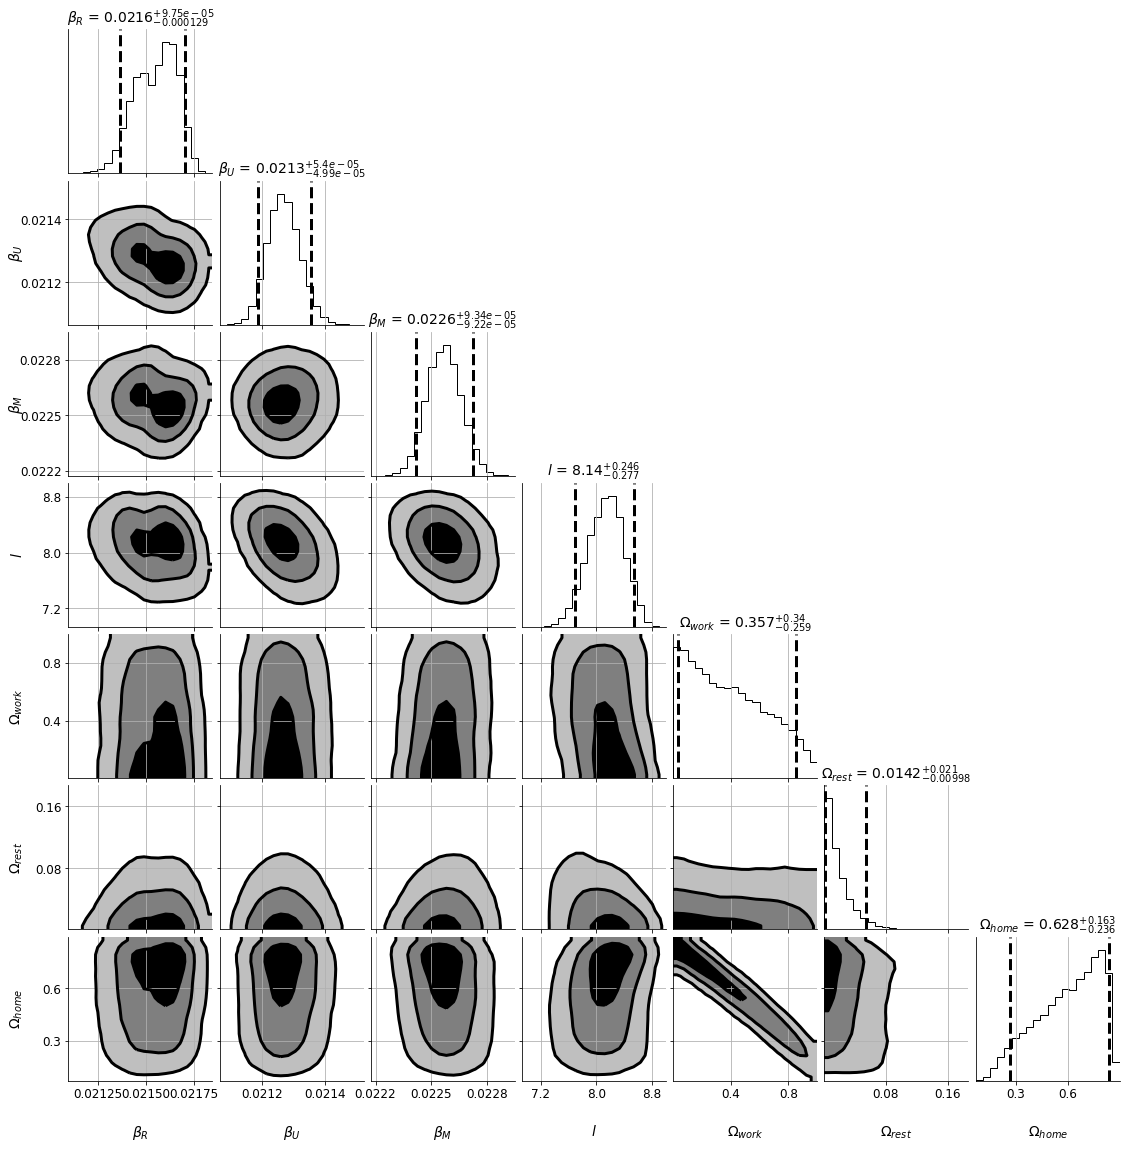

In [140]:
CORNER_KWARGS_WAVE1 = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=14),
    title_kwargs=dict(fontsize=14),
    quantiles=[0.05, 0.95],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=3,
    title_fmt=".3"
)
    # range=[(0,0.12),(0,5.2),(0,15)] # add this to CORNER_KWARGS if range is not automatically good

# Cornerplots of samples
fig = corner.corner(flat_samples_WAVE1, labels=labels_WAVE1, **CORNER_KWARGS_WAVE1)

for idx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=12, rotation=0)

# Save figure
fig.show()
savename_WAVE1 = f'../../results/calibrations/COVID19_SEIRD/arr/cornerplots/{json_name[:-5]}_CORNER.png'
# fig.savefig(savename, dpi=400, bbox_inches='tight')
# plt.close()

## Fit to data

### Load model data

In [141]:
# Load and format mobility dataframe
proximus_mobility_data, proximus_mobility_data_avg = mobility.get_proximus_mobility_data(agg, dtype='fractional', beyond_borders=False)
# Converting the index as date. Probably not necessary because it's already done.
# all_mobility_data.index = pd.to_datetime(all_mobility_data.index)

# Total population and contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices(spatial=agg)

# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)

# Sciensano data: *hospitalisations* (H_in) moving average at spatial level {agg}. Column per NIS code
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, moving_avg=moving_avg, values='hospitalised_IN')

### Time-dependant data

In [142]:
# Mobility update function from class __call__ and function wrapper to get the right signature
mobility_wrapper_function = make_mobility_update_function(proximus_mobility_data, proximus_mobility_data_avg).mobility_wrapper_func

# Social behaviour update function from class __call__ (contact_matrix_4prev) and function wrapper to get the right signature
policies_WAVE1 = make_contact_matrix_function(df_google, Nc_all).policies_WAVE1

### Load model

In [143]:
# Load the model parameters dictionary
params_WAVE1 = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, VOC=False)
# Add the time-dependant parameter function arguments
params_WAVE1.update({'l' : 5, # formality
               'prev_home' : 0.5, # formality
               'prev_schools': 0.0, # formality
               'prev_work': 0.5, # formality
               'prev_rest': 0.5 # formality
              })
# Add parameters for the daily update of proximus mobility
# mobility defaults to average mobility of 2020 if no data is available
params_WAVE1.update({'default_mobility' : None})

# --------------------
# Model initialisation
# --------------------

# Initial states, depending on args parser. Age is hard-coded
age=40
initE = initial_state(dist=init_WAVE1, agg=agg, age=age, number=init_number_WAVE1) # 40-somethings dropped in Brussels (arrival by plane)
initial_states_WAVE1 = {'S': initN, 'E': initE}

# Initiate model with initial states, defined parameters, and proper time dependent functions
model_WAVE1 = models.COVID19_SEIRD_spatial(initial_states_WAVE1, params_WAVE1, time_dependent_parameters = \
                                           {'Nc' : policies_WAVE1, 'place' : mobility_wrapper_function}, spatial=agg)


In [146]:
if job_WAVE1 == 'R0':
    def draw_fcn_WAVE1(param_dict,samples_dict):
        # pick one random value from the dictionary
        idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
        # take out the other parameters that belong to the same iteration
        param_dict['beta_U'] = samples_dict['beta_U'][idx]
        param_dict['beta_M'] = samples_dict['beta_M'][idx]
        return param_dict
elif job_WAVE1 == 'FULL':
    def draw_fcn_WAVE1(param_dict,samples_dict):
        # pick one random value from the dictionary
        idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
        # take out the other parameters that belong to the same iteration
        param_dict['beta_U'] = samples_dict['beta_U'][idx]
        param_dict['beta_M'] = samples_dict['beta_M'][idx]
        param_dict['l'] = samples_dict['l'][idx]
        param_dict['prev_home'] = samples_dict['prev_home'][idx]
        param_dict['prev_work'] = samples_dict['prev_work'][idx]
        param_dict['prev_rest'] = samples_dict['prev_rest'][idx]
        return param_dict

In [147]:
start_sim_WAVE1 = samples_dict_WAVE1[f'start_date_{job_WAVE1}']
# Note that we can choose to simulate further than the calibration date
end_sim_WAVE1 = '2020-09-01'
warmup_WAVE1 = samples_dict_WAVE1['warmup']
n_samples_WAVE1 = 100
out_WAVE1 = model_WAVE1.sim(end_sim_WAVE1,start_date=start_sim_WAVE1,warmup=warmup_WAVE1,N=n_samples_WAVE1,draw_fcn=draw_fcn_WAVE1,samples=samples_dict_WAVE1, verbose=True)

### Plot calibration fit
Note how this _does not_ plot the full parameter dictionary, but only a sample of size `n_samples`. Surely there is a more complete way of going about?

Note also that the central 'median' line that is plotted, is the result of a single simulation. By definition, it is only in the middle of the band at the peak. That is an important nuance.

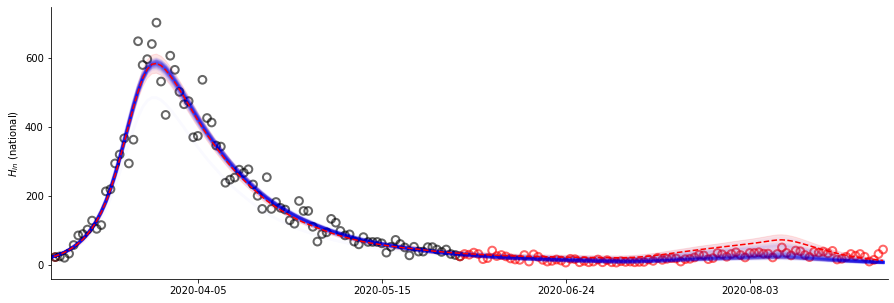

In [169]:
savename_WAVE1 = f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name_WAVE1[:-5]}_FIT.png'
savename_WAVE1=None
NIS_WAVE1=None

start_calibration_WAVE1 = start_sim_WAVE1
end_calibration_WAVE1 = samples_dict_WAVE1[f'end_date_{job_WAVE1}']

fig, ax = plt.subplots(figsize=(15,5))

ax, median_draw_WAVE1 = plot_calibration_fit(out_WAVE1, df_sciensano, 'H_in', start_sim_WAVE1, end_sim_WAVE1, \
            start_calibration=start_calibration_WAVE1, end_calibration=end_calibration_WAVE1, NIS=NIS_WAVE1, \
            savename=savename_WAVE1, conf_int=0.05, show_all=True, ax=ax)
ax.grid(False)

In [ ]:
run_again_WAVE1=False

if run_again_WAVE1:
    nis_list = pd.read_csv("../../data/raw/GIS/NIS_arrondissement.csv")['NIS'].values
    median_draws=np.zeros(len(nis_list))
    for idx, NIS in enumerate(nis_list):
        savename = f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name[:-5]}_FIT_{NIS}.png'
        savename = None
        ax, median_draws[idx] = plot_calibration_fit(out, df_sciensano, 'H_in', start_sim, end_sim, NIS=NIS, savename=savename)
        ax.grid(False)

### Save subjects per states at particular date (start dict for next waves)
Save from median run

In [41]:
out_median = out.sel(draws=median_draw_WAVE1)

final_states = {}
for state in list(out.data_vars.keys()):
    final_states.update({state: out_median[state].sel(time=end_sim, method='nearest').values.tolist()})
    
# Saves list (43 entries) of lists (9 entries) for each state.
final_states_json = f'{json_loc}/{agg}_WAVE1_job-{job}_{str(maxiter)}xPSO_{str(number)}xMCMC_{agg}_{str(init_number)}-index-in-{init}_{date}_states_{end_sim}.json'
with open(final_states_json, 'w') as fsj:
    json.dump(final_states, fsj)

# Postprocessing WAVE2

In [181]:
##################
### USER INPUT ###
##################

# can take a while

# Simulation properties
agg = 'arr'
job_WAVE2 = 'FULL'
maxiter_WAVE2 = 100
number_WAVE2 = 100
date_WAVE2 = '2021-06-04' # Date of calibration execution

moving_avg = False

###################

# Automated name
json_name_WAVE2 = f"{agg}_WAVE2-{job_WAVE2}_job-{job_WAVE2}_{str(maxiter_WAVE2)}xPSO_{str(number_WAVE2)}xMCMC_{agg}.json"
json_name_WAVE2 = 'arr_WAVE2-FULL_test_delete_me_2021-06-04.json'
json_loc_WAVE2 = f"../../data/interim/model_parameters/COVID19_SEIRD/calibrations/{agg}"

# Load dict and thin/discard
samples_dict_WAVE2 = json.load(open(f'{json_loc_WAVE2}/{json_name_WAVE2}'))
parNames_mcmc_WAVE2 = ['beta_R', 'beta_U', 'beta_M']
labels_WAVE2 = ['$\\beta_R$', '$\\beta_U$', '$\\beta_M$']
if job_WAVE2 == 'FULL':
    parNames_mcmc_WAVE2 += ['l', 'prev_schools', 'prev_work', 'prev_rest', 'prev_home']
    labels_WAVE2 += ['$l$', '$\Omega_{schools}$', '$\Omega_{work}$', '$\Omega_{rest}$', '$\Omega_{home}$']
nwalkers_WAVE2=int(samples_dict[f'n_chains_{job}'])
discard_WAVE2=0
thin_WAVE2=10
samples_WAVE2,flat_samples_WAVE2 = samples_dict_to_emcee_chain(samples_dict_WAVE2, parNames_mcmc_WAVE2, nwalkers_WAVE2, discard=discard_WAVE2, thin=thin_WAVE2)

# len(samples_dict['beta_R'])/50
# samples_dict['warmup']

samples_dict_WAVE2.keys()

dict_keys(['beta_R', 'beta_U', 'beta_M', 'l', 'prev_schools', 'prev_work', 'prev_rest', 'prev_home', 'warmup', 'start_date_FULL', 'end_date_FULL', 'n_chains_FULL'])

## Traceplot

See `results/calibrations/COVID19_SEIRD/{agg}/traceplots`

## Autocorrelation

See `results/calibrations/COVID19_SEIRD/{agg}/autocorrelation`

## Corner plots

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


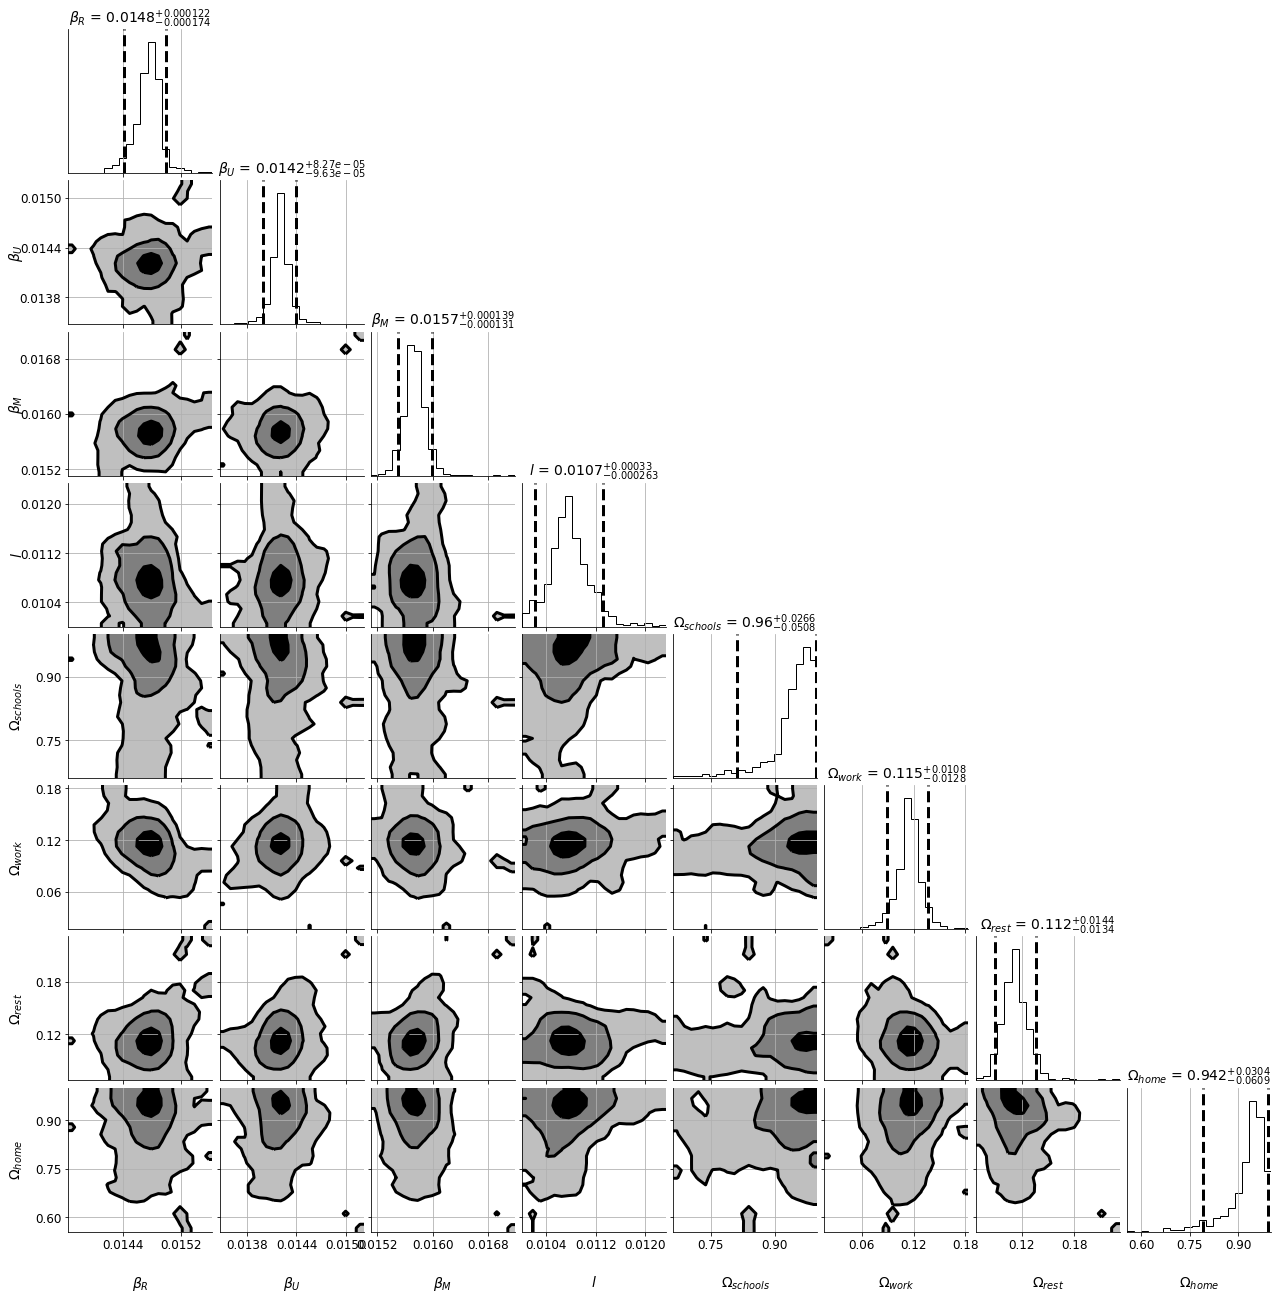

In [182]:
CORNER_KWARGS_WAVE2 = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=14),
    title_kwargs=dict(fontsize=14),
    quantiles=[0.05, 0.95],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=3,
    title_fmt=".3"
)
    # range=[(0,0.12),(0,5.2),(0,15)] # add this to CORNER_KWARGS if range is not automatically good

# Cornerplots of samples
fig = corner.corner(flat_samples_WAVE2, labels=labels_WAVE2, **CORNER_KWARGS_WAVE2)

for idx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=12, rotation=0)

# Save figure
fig.show()
savename_WAVE2 = f'../../results/calibrations/COVID19_SEIRD/arr/cornerplots/{json_name_WAVE2[:-5]}_CORNER.png'
# fig.savefig(savename_WAVE2, dpi=400, bbox_inches='tight')
# plt.close()

## Fit to data

### Load model data

In [154]:
# Load and format mobility dataframe
proximus_mobility_data, proximus_mobility_data_avg = mobility.get_proximus_mobility_data(agg, dtype='fractional', beyond_borders=False)
# Converting the index as date. Probably not necessary because it's already done.
# all_mobility_data.index = pd.to_datetime(all_mobility_data.index)

# Total population and contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices(spatial=agg)

# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)

# Sciensano data: *hospitalisations* (H_in) moving average at spatial level {agg}. Column per NIS code
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, moving_avg=moving_avg, values='hospitalised_IN')

### Time dependant data

In [155]:
# Mobility update function from class __call__ and function wrapper to get the right signature
mobility_wrapper_function = make_mobility_update_function(proximus_mobility_data, proximus_mobility_data_avg).mobility_wrapper_func

# Social behaviour update function from class __call__ (contact_matrix_4prev) and function wrapper to get the right signature
policies_WAVE2_full_relaxation = make_contact_matrix_function(df_google, Nc_all).policies_WAVE2_full_relaxation

### Load model

In [156]:
# Load the model parameters dictionary
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, VOC=False)
# Add the time-dependant parameter function arguments
params.update({'l' : 5, # formality
               'prev_home' : 0.5, # formality
               'prev_schools': 0.0, # formality
               'prev_work': 0.5, # formality
               'prev_rest': 0.5, # formality
               'relaxdate' : '2021-07-01', # new parameter, only relevant for 2021
               'l_relax' : 31 # new parameter, only relevant for 2021
              })
# Add parameters for the daily update of proximus mobility
# mobility defaults to average mobility of 2020 if no data is available
params.update({'default_mobility' : None})

# --------------------
# Model initialisation
# --------------------

# User-defined initial states json file
initial_states_loc = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr'
initial_states_json = 'arr_WAVE1_job-FULL_1000xPSO_20000xMCMC_arr_3-index-in-frac_2021-06-02_states_2020-09-01.json'
# Initial states, depending on args parser. Taken from WAVE1
with open(f'{initial_states_loc}/{initial_states_json}', 'r') as fp:
    initial_states = json.load(fp) 

# Initiate model with initial states, defined parameters, and proper time dependent functions
model = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters = \
                                           {'Nc' : policies_WAVE2_full_relaxation, 'place' : mobility_wrapper_function}, spatial=agg)

print(f"Initial new hospitalisations: {round(np.sum(initial_states['H_in']),2)}")

Initial new hospitalisations: 6.32


In [157]:
if job == 'R0':
    def draw_fcn(param_dict,samples_dict):
        # pick one random value from the dictionary
        idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
        # take out the other parameters that belong to the same iteration
        param_dict['beta_U'] = samples_dict['beta_U'][idx]
        param_dict['beta_M'] = samples_dict['beta_M'][idx]
        return param_dict
elif job == 'FULL':
    def draw_fcn(param_dict,samples_dict):
        # pick one random value from the dictionary
        idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
        # take out the other parameters that belong to the same iteration
        param_dict['beta_U'] = samples_dict['beta_U'][idx]
        param_dict['beta_M'] = samples_dict['beta_M'][idx]
        param_dict['l'] = samples_dict['l'][idx]
        param_dict['prev_schools'] = samples_dict['prev_schools'][idx]
        param_dict['prev_home'] = samples_dict['prev_home'][idx]
        param_dict['prev_work'] = samples_dict['prev_work'][idx]
        param_dict['prev_rest'] = samples_dict['prev_rest'][idx]
        return param_dict

In [158]:
start_sim = '2020-09-01'
# Note that we can choose to simulate further than the calibration date
end_sim = '2020-12-31'
warmup = samples_dict['warmup']
n_samples = 100
out = model.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict, verbose=True)

### Plot calibration fit
Note how this _does not_ plot the full parameter dictionary, but only a sample of size `n_samples`. Surely there is a more complete way of going about?

Note also that the central 'median' line that is plotted, is the result of a single simulation. By definition, it is only in the middle of the band at the peak. That is an important nuance.

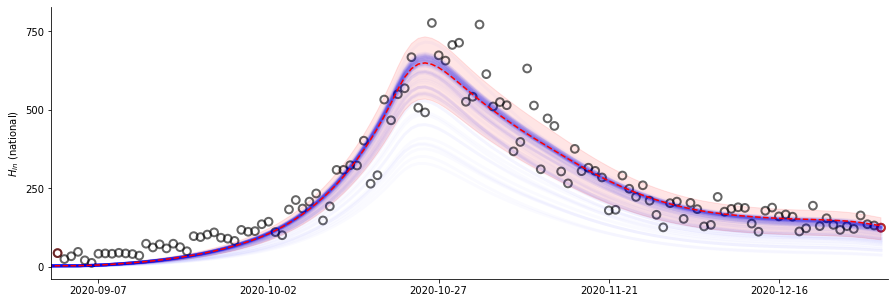

In [168]:
savename = f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name[:-5]}_FIT.png'
savename=None
NIS=None

start_calibration = samples_dict[f'start_date_{job}']
end_calibration = samples_dict[f'end_date_{job}']

fig, ax = plt.subplots(figsize=(15,5))

ax, median_draw = plot_calibration_fit(out, df_sciensano, 'H_in', start_sim, end_sim, \
            start_calibration=start_calibration, end_calibration=end_calibration, NIS=NIS, \
            savename=savename, conf_int=0.05, show_all=True, ax=ax)
ax.grid(False)
# ax.set_ylim([0, 10])

In [129]:

# df_sciensano.loc[start_sim].values
# np.array(initial_states['H_in']).sum(axis=1)

pd.read_csv(f"../../data/interim/nonpublic_timeseries/all_nonpublic_timeseries_{agg}.csv")

,name,inhabitants,DATE,NIS_arr,confirmed_cases,tested_cases,confirmed_per_tested_5days_window,hospitalised_IN,recovered,deceased_hosp,ICU,confirmed_cases_per_100k,hospitalised_IN_per_100k,recovered_per_100k,deceased_hosp_per_100k,ICU_per_100k
0,Arrondissement Antwerpen,1057736.0,2020-03-02,11000,0.0,27.0,NaN,2.0,NaN,NaN,0.0,0.000000,0.189083,NaN,NaN,0.000000
1,Arrondissement Antwerpen,1057736.0,2020-03-03,11000,4.0,75.0,0.044369,1.0,NaN,NaN,0.0,0.378166,0.094542,NaN,NaN,0.000000
2,Arrondissement Antwerpen,1057736.0,2020-03-04,11000,3.0,100.0,0.040984,4.0,NaN,NaN,NaN,0.283625,0.378166,NaN,NaN,NaN
3,Arrondissement Antwerpen,1057736.0,2020-03-05,11000,5.0,80.0,0.039024,2.0,0.0,NaN,0.0,0.472708,0.189083,0.0,NaN,0.000000
4,Arrondissement Antwerpen,1057736.0,2020-03-06,11000,3.0,84.0,0.048223,0.0,NaN,NaN,1.0,0.283625,0.000000,NaN,NaN,0.094542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18657,Arrondissement Philippeville,66315.0,2021-05-05,93000,45.0,463.0,0.084993,0.0,0.0,0.0,NaN,67.857951,0.000000,0.0,0.0,NaN
18658,Arrondissement Philippeville,66315.0,2021-05-06,93000,28.0,437.0,0.075567,1.0,0.0,0.0,NaN,42.222725,1.507954,0.0,0.0,NaN
18659,Arrondissement Philippeville,66315.0,2021-05-07,93000,20.0,393.0,0.068653,0.0,0.0,0.0,0.0,30.159089,0.000000,0.0,0.0,0.000000
18660,Arrondissement Philippeville,66315.0,2021-05-08,93000,13.0,251.0,NaN,0.0,NaN,0.0,NaN,19.603408,0.000000,NaN,0.0,NaN


In [ ]:
run_again=False

if run_again:
    nis_list = pd.read_csv("../../data/raw/GIS/NIS_arrondissement.csv")['NIS'].values
    median_draws=np.zeros(len(nis_list))
    for idx, NIS in enumerate(nis_list):
        savename = f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name[:-5]}_FIT_{NIS}.png'
        savename = None
        ax, median_draws[idx] = plot_calibration_fit(out, df_sciensano, 'H_in', start_sim, end_sim, NIS=NIS, savename=savename)
        ax.grid(False)

# Experiment with initial condition

The idea is to consider ...
1. The reported 7-day averaged number of hospitalisations at September 1st
2. The median predicted number of hospitalisations at September 1st
3. The ratio between these PER REGION
    1. If the ratio is zero, keep the original simulation number
    2. Otherwise, change the content of the following categories: E, I, A, M, C

In [189]:
initial_states.keys()

dict_keys(['S', 'E', 'I', 'A', 'M', 'C', 'C_icurec', 'ICU', 'R', 'D', 'H_in', 'H_out', 'H_tot'])

In [188]:
# Sciensano data 7-day average per NIS
# Note that some of these values are zero (no hospitalisations all week)
hosp_sciensano = np.array(sciensano.get_sciensano_COVID19_data_spatial(agg=agg, moving_avg=True, values='hospitalised_IN').loc['2020-09-01'].values)

# Simulation predictions
hosp_simulation = np.array(initial_states['H_in']).sum(axis=1)

# hosp_sciensano / hosp_simulation

hosp_simulation

array([0.59979978, 0.20547673, 0.27590156, 0.66271511, 0.37662731,
       0.29507318, 0.23141363, 0.18908426, 0.02534094, 0.05834289,
       0.17336864, 0.10933252, 0.09005387, 0.05431518, 0.04818738,
       0.17720063, 0.12098774, 0.05149478, 0.31897146, 0.0730178 ,
       0.14789889, 0.06495674, 0.20363606, 0.13042605, 0.05466197,
       0.03838434, 0.12371492, 0.07495771, 0.05069923, 0.32062569,
       0.11935047, 0.03970895, 0.24123686, 0.14142633, 0.11892774,
       0.02337202, 0.01384573, 0.02023193, 0.01855783, 0.01580759,
       0.0402178 , 0.15677879, 0.02291438])